In [1]:
'''
the my_utils file was recieved from the d2l web textbook and contains many functions
for use with pytorch. A slight modification was made to the train_c6 funciton 
so that now it requires the input of the optimiser and loss functions,
rather than featuring them inately.
'''

import my_utils as mu
import torch
from torch import nn

loss 0.173, train acc 0.934, test acc 0.865
8750.0 examples/sec on cuda:0


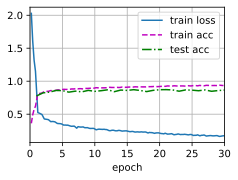

In [129]:
'''
The hyperparameters for the learning operation are defined here
'''
#testing/training batch sizes, learning rate, number of epochs in the training
batch_size, lr, num_epochs = 256, 0.05, 30
#dimensions of the input images, dimensions of the output classifications
input_dim, output_dim = 28, 10
#size of the patches taken of the image in the step
patch_size = 4
#number of backbone blocks present in the model
N_blocks = 3
#how many hidden dimensions are present in the model
hidden_dim = 20
#how many dimensions the linear layers use
mlp_dim = 160

n_patches = int(input_dim ** 2/patch_size**2)
'''
The modules that will be run at the start of the nn.sequencial are defined here.
This is the stem of the pipeline, and only a single layer non-overlapping convolutional 
layer is created as instructed on the coursework specification.

The convolution layer intrepets the input image in patches (KxK), defined by the patch_size variable.
To ensure that none of the patches are overlapping, the kernel size and stride are set equal
to eachother. To ensure that no overlapping occurs, the patches must be a factor of the 
input resolution (28)

Once patches have been taken the data is flattened/vectorised for the backbone process and 
transposed.
'''
    
#the creation of the tranpose action for use in nn.Sequential
class my_transpose(nn.Module):
    def forward(self, x):
        return torch.transpose(x,-1,-2)

#stem modules for use in nn.sequential
modules = [nn.Conv2d(in_channels = 1, 
                     out_channels = hidden_dim, 
                     kernel_size = patch_size, 
                     stride = patch_size),
           nn.Flatten(2),
           my_transpose()
          ]

'''
This part of the code defines the backbone of the model and the output for the classifier

For each N_block the following pipeline steps are added:
-The patches which outputted from the stem, with a certain amount of hidden layers, are normalised
with the layernorm function. 
-The data is then transposed and fed into a Linear - activation - Linear MLP. 
-The data is transposed again and the transposed data is fed into another linear - activation - linear MLP
- on the final block the results are averaged/vectorised and appropriately parsed into 10 output variables
for the classifier
'''

class my_mean(nn.Module):
    def forward(self, x):
        return torch.mean(x,dim=1)
    
#since each block in the backbone consists of 2 MLPs, the range over which the 
#modules iterate the blocks is double the number of blocks. 
for i in range(N_blocks):
    modules.append(nn.LayerNorm(hidden_dim))
    modules.append(my_transpose())
    modules.append(nn.Linear(n_patches, mlp_dim))
    modules.append(nn.ReLU())
    modules.append(nn.Linear(mlp_dim, n_patches))
    modules.append(my_transpose())
    modules.append(nn.LayerNorm(hidden_dim))
    modules.append(nn.Linear(hidden_dim, mlp_dim))
    modules.append(nn.ReLU())
    modules.append(nn.Linear(mlp_dim, hidden_dim))

    if i == N_blocks - 1:
        modules.append(my_mean())
        modules.append(nn.Linear(hidden_dim, output_dim))
        
#here the model modules are put into the pytorch sequentuial function, so they can be used
#on the data
net = nn.Sequential(*modules)

'''
The following section loads the data, sets up training environment and feeds the output
into a softmax classifier defined in my_utils.
'''
#here the testing and training data iterators are obtained from a my_util function
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

#here the stochastic gradient descent training optimiser and CEloss functions are defined
#(softmax)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

#using the modified train_ch6 function from my_utils, the ML pipeline can be used in 
#conjunction with data, and a graph showing the progress of the algorithm is created
mu.train_ch6(net, 
             train_iter, 
             test_iter, 
             num_epochs, 
             optimizer,
             loss, 
             device = mu.try_gpu()
            )


In [126]:
print(net)

Sequential(
  (0): Conv2d(1, 20, kernel_size=(2, 2), stride=(2, 2))
  (1): Flatten(start_dim=2, end_dim=-1)
  (2): my_transpose()
  (3): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  (4): my_transpose()
  (5): Linear(in_features=196, out_features=160, bias=True)
  (6): ReLU()
  (7): Linear(in_features=160, out_features=196, bias=True)
  (8): my_transpose()
  (9): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  (10): Linear(in_features=20, out_features=160, bias=True)
  (11): ReLU()
  (12): Linear(in_features=160, out_features=20, bias=True)
  (13): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  (14): my_transpose()
  (15): Linear(in_features=196, out_features=160, bias=True)
  (16): ReLU()
  (17): Linear(in_features=160, out_features=196, bias=True)
  (18): my_transpose()
  (19): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  (20): Linear(in_features=20, out_features=160, bias=True)
  (21): ReLU()
  (22): Linear(in_features=160, out_features=20, bias=Tru